## Import libraries

In [1]:
# import necessary libraries
import os
from PIL import Image
import pathlib
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
tf.get_logger().setLevel('ERROR')
# Importing necessary libraries 
from tensorflow.keras import Sequential, layers
#from tensorflow.keras.applications. 
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Al.zip 

Streaming output truncated to the last 5000 lines.
  inflating: Al/face-detection/venv/Lib/site-packages/numpy/core/tests/data/umath-validation-set-tan.csv  
  inflating: __MACOSX/Al/face-detection/venv/Lib/site-packages/numpy/core/tests/data/._umath-validation-set-tan.csv  
  inflating: Al/face-detection/venv/Lib/site-packages/numpy/core/tests/data/umath-validation-set-exp.csv  
  inflating: __MACOSX/Al/face-detection/venv/Lib/site-packages/numpy/core/tests/data/._umath-validation-set-exp.csv  
  inflating: Al/face-detection/venv/Lib/site-packages/numpy/core/tests/data/astype_copy.pkl  
  inflating: __MACOSX/Al/face-detection/venv/Lib/site-packages/numpy/core/tests/data/._astype_copy.pkl  
  inflating: Al/face-detection/venv/Lib/site-packages/numpy/core/lib/npy-pkg-config/npymath.ini  
  inflating: __MACOSX/Al/face-detection/venv/Lib/site-packages/numpy/core/lib/npy-pkg-config/._npymath.ini  
  inflating: Al/face-detection/venv/Lib/site-packages/numpy/core/lib/npy-pkg-config/mlib.ini 

In [4]:
data_dir = '/content/Al/face-detection/images/gender/'
n_epochs = 15

img_width = 128
img_height = 128
gray = False

## Visualization

In [5]:
male_paths = list(paths.list_images(data_dir + 'male'))
female_paths = list(paths.list_images(data_dir + 'female'))

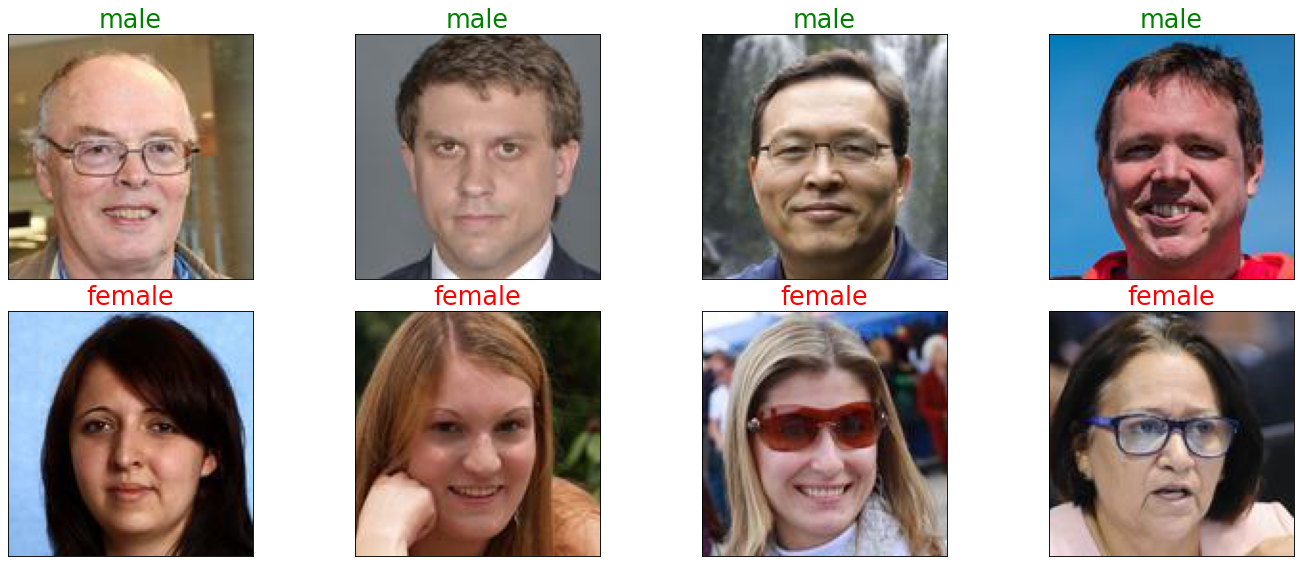

In [6]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 7),  dpi=80, sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < 4:
      ax.imshow(plt.imread(male_paths[i]))
      ax.set_title("male", fontsize = 23, color='green')
    else:
      ax.imshow(plt.imread(female_paths[i]))
      ax.set_title("female", fontsize = 23, color='red')

plt.tight_layout(pad=0.5)
plt.show()

## Preprocessing

In [7]:
import glob
import cv2

def get_images_path(dataset_path):
    list_path = []
    for img_path in glob.glob(f'/{dataset_path}/*/*'):
        list_path.append(img_path)
    return list_path


def path_split(dataset_path, seed=432):
    """
    Extracts image paths existing in the dataset and then splits to train, validation and test sets.
    :param dataset_path: the path of dataset
    :param seed: the seed required to random shuffle files
    :return: 
    """
    imgpaths = get_images_path(dataset_path)
    train_path, test_path = train_test_split(imgpaths, test_size=0.15, random_state=seed, shuffle=True)
    return train_path, test_path


def data_extractor(image_paths, img_height, img_width, gray=False):
    """
    This function reads the image existing in the input path and 
    doing some preprocessing operations on it.besides extracts the image label them.
    :param image_paths: the input image path
    :param height: resized image height
    :param width: resized image width
    :return: image and label arrays
    """
    data=[]
    labels = []
    for imagepath in image_paths:
        image = cv2.imread(imagepath)
        if gray:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image,(img_height, img_width),interpolation=cv2.INTER_AREA)
        label = imagepath.split(os.sep)[-2]
        label = 0 if label=='male' else 1
        labels.append(label)
        data.append(image)
    if gray:
        return np.expand_dims(data, axis=-1)/255.0, np.array(labels)
    else:
        return np.array(data)/255.0, np.array(labels)


# Data augmentation layer
def augmentation_layer():
    return tf.keras.Sequential([                        
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomContrast(factor=0.3),
    preprocessing.RandomWidth(factor=0.15),
    preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)])

In [8]:
# get image paths and split into train and test
train_path, test_path = path_split(data_dir)

In [9]:
len(train_path), len(test_path)

(8500, 1500)

In [10]:
# Preprocessing and Labeling
train_X, train_y = data_extractor(train_path, img_height, img_width, gray)
test_X, test_y = data_extractor(test_path, img_height, img_width, gray)

### Build the model
Here we will build the CNN classifier. Unlike general Convolution Layer, we will define custom Convolution Layer class with Batch normalization. 

Note that when we use Batch normalization, we need to define whether it is used in training mode or not. Because Batch normalization is one of approaches to help training easily, but in test/validation mode, weight may not be updated. At that case, `training` argument must be `False`. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) of this usage.

In [11]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn =   tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

Using this class, we implement CNN model with Sequential API. And output node will be 2 since our classifier can classify two labels: (or 0 and 1).

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))

In [13]:
model(train_X[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5235363]], dtype=float32)>

### Model Checkpoint
From previous post, we used ModelCheckPoint for saving weight of model. Through this, we can save the weight that trained model can perform best accuracy. Or we can load the best model to enhance the performance.

In [14]:
# Callbacks
Callbacks = [callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=0)]

### Compile Model
# Actually, All process until here, is the task to define the model. To use the model for training, it is required to define the optimizer and loss function.

**Adaptive Momentum estimation** (Adam for short) is widely used optimizer to find the optimal solution for minimum loss. There needs to be defined learning_rate ($\eta$) for step_size. In this case, we use `1e-4` (or 0.00004) as a learning_rate.

And There are many loss function for classification. Maybe someone confuses about what kind of loss function that can we choose from [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) or [Cross Entropy Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy). Cross Entropy Loss is used for classification when there are two or more label classes. But mentioned in documentation, if the label is provided as an integer (not float or whatever), we need to use `SparseCategoricalCrossentropy`. 

The last argument we need to define is metrics. Metrics is the numerical result to check the performance. Our case is classification, and the performance of classification can be measured from comparing predicted label and ground truth label. So the metrics we need to define is `accuracy` (of course, we can define multiple metrics as a list type)

In [15]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 126, 126, 32)         896       
                                                                 
 batch_normalization (BatchN  (1, 126, 126, 32)        128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (1, 126, 126, 32)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (1, 63, 63, 32)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (1, 61, 61, 64)           18496     
                                                                 
 batch_normalization_1 (Batc  (1, 61, 61, 64)          2

Finally, we can extract the summary of our CNN model that have almost 2.5 million parameters.

## plot the model

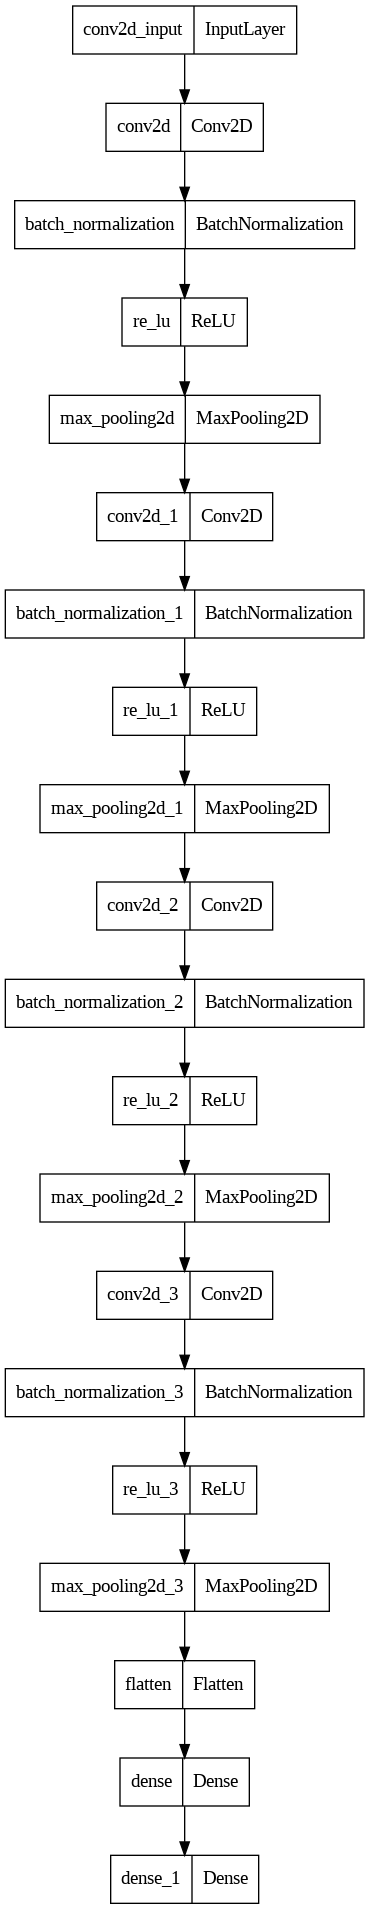

In [16]:
plot_model(model)

### Train the model
We can train our model with `.fit()` method. And also we need to use checkpoint callback that we defined earlier.

In [17]:
model.fit(train_X, train_y, epochs=n_epochs, batch_size=32, validation_data=(test_X, test_y), callbacks=Callbacks)

Epoch 1/15
266/266 [==============================] - 18s 41ms/step - loss: 0.4244 - accuracy: 0.8502 - val_loss: 0.5294 - val_accuracy: 0.6713
Epoch 2/15
266/266 [==============================] - 8s 31ms/step - loss: 0.1481 - accuracy: 0.9395 - val_loss: 0.1633 - val_accuracy: 0.9380
Epoch 3/15
266/266 [==============================] - 8s 32ms/step - loss: 0.0889 - accuracy: 0.9658 - val_loss: 0.1765 - val_accuracy: 0.9440
Epoch 4/15
266/266 [==============================] - 8s 32ms/step - loss: 0.0658 - accuracy: 0.9735 - val_loss: 0.1186 - val_accuracy: 0.9547
Epoch 5/15
266/266 [==============================] - 8s 30ms/step - loss: 0.0472 - accuracy: 0.9839 - val_loss: 0.1237 - val_accuracy: 0.9500
Epoch 6/15
266/266 [==============================] - 9s 32ms/step - loss: 0.0364 - accuracy: 0.9871 - val_loss: 0.1290 - val_accuracy: 0.9587
Epoch 7/15
266/266 [==============================] - 8s 31ms/step - loss: 0.0200 - accuracy: 0.9934 - val_loss: 0.2131 - val_accuracy: 0.946

### Model Evaluation


In [18]:
model.evaluate(test_X, test_y)

47/47 [==============================] - 1s 14ms/step - loss: 0.1456 - accuracy: 0.9687


[0.14558075368404388, 0.968666672706604]

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_curve
from mlxtend.plotting import plot_confusion_matrix

In [20]:
def map_y(y_pred):
  labels = []
  for y in y_pred:
    if y < 0.5:
      labels.append(0)
    else:
      labels.append(1)
  return labels

47/47 [==============================] - 1s 11ms/step
Accuracy : 0.9686666666666667
Precision: 0.9566360052562418
Recall   : 0.9811320754716981
F1 score : 0.9687292082501663
Specificity : 0.9564643799472295

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       758
           1       0.96      0.98      0.97       742

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500





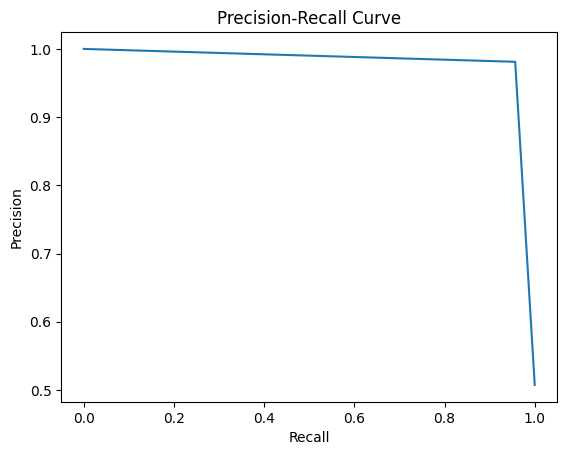

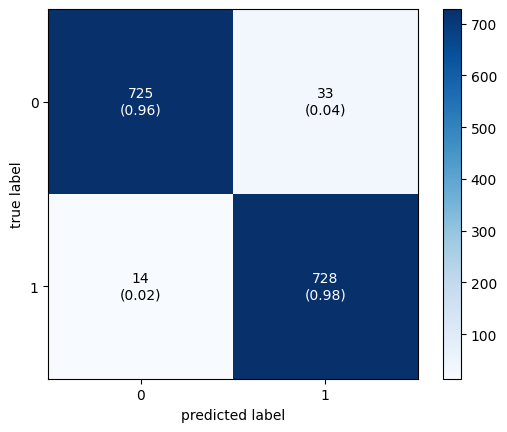

In [21]:
y_pred = model.predict(test_X)
y_predictions = map_y(y_pred)
cm = confusion_matrix(y_predictions, test_y)

tn = cm[0,0]
fp = cm[0,1]
tp = cm[1,1]
fn = cm[1,0]
accuracy  = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall    = tp / (tp + fn)
f1score  = 2 * precision * recall / (precision + recall)
specificity = tn / (tn + fp)
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'F1 score : {f1score}')
print(f'Specificity : {specificity}')
print("") 
print(f'Classification Report: \n{classification_report(y_predictions, test_y)}\n')
print("")

precision, recall, thresholds = precision_recall_curve(test_y, y_predictions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

# Plot non-normalized confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                            show_absolute=True,
                            show_normed=True,
                            colorbar=True)
plt.show()


## Save the model

In [22]:
# save the model
model.save('/content/drive/MyDrive/Model_Image/model_conv.h5')

In [23]:
# Delete the model
del model

## Test

In [24]:
# Pre-processing for test images
def test_preprocessing(img_path, gray=True):
    image = cv2.imread(img_path)
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_AREA)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

In [25]:
# load model
model = load_model('/content/drive/MyDrive/Model_Image/model_conv.h5')

In [26]:
import io
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

def visualize_image(image, y_pred):
    # Do the actual drawing in python
    fig = plt.figure(figsize=(3, 3), dpi=80)
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    if y_pred < 0.5:
      ax.text(2, 8, "Male",fontweight='bold', color='green',  bbox = dict(facecolor = 'gold', alpha =.9), fontsize='large')
    else:
      ax.text(0, 10, "Female",fontweight='bold', color='red',  bbox = dict(facecolor = 'gold', alpha =.9), fontsize='large')
    fig.canvas.draw()
    plt.tight_layout()

In [27]:
def inference(image_path):
  # read the test image
  img = cv2.imread(test_img_path)

  # Pre-processing
  test_image = test_preprocessing(test_img_path, gray)
  # prediction
  y_pred = model.predict(test_image, verbose=0)[0][0]

  # print(y_pred)
  visualize_image(img, y_pred)

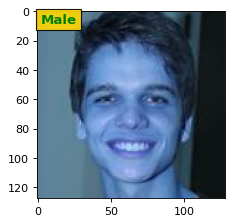

In [29]:
# test image path
test_img_path = '4.jpg'
inference(test_img_path)

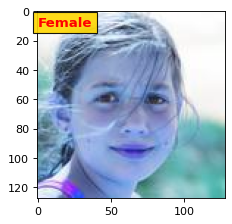

In [31]:
# test image path
test_img_path = '8.jpg'
inference(test_img_path)

### Transfer Learning
We built our CNN model for face detection  classification. But can we make our model with state-of-the-art approach? For those who want to use state-of-the-art model, there are some pretrained model, like `efficientNet`, `inception`, `vgg` etc. (check the detail usage in [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)).

In this section, we will build our model with VGG16.

![vgg16](image/vgg16-neural-network.jpg)

VGG16 was introduced in the ILSVRC 2014. You can check the detail architecture and implementation from the [paper](https://arxiv.org/abs/1409.1556) (Simonyan et al, 2014). You can borrow the structure of model as an convolutional layer like our `Conv` layer.

In [32]:
from tensorflow.keras.applications import InceptionResNetV2, VGG19

def initialize_model(imgs_height, imgs_width, n_channels):
    conv_base = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(imgs_height, imgs_width, n_channels))
    # conv_base = VGG19(include_top=False, weights='imagenet', input_shape=(imgs_height, imgs_width, n_channels))

    for layer in conv_base.layers:
        layer.trainable = False

    input_ = keras.Input(shape=(imgs_height, imgs_width, n_channels))
    x = augmentation_layer()(input_)
    x = Resizing(imgs_height, imgs_width)(x)

    model=Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    return model


# defining a function for compile the model
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [33]:
model = initialize_model(128, 128, 3)

219055592/219055592 [==============================] - 7s 0us/step


In [34]:
# compile the model
model = compile_model(model) 

## plot the model

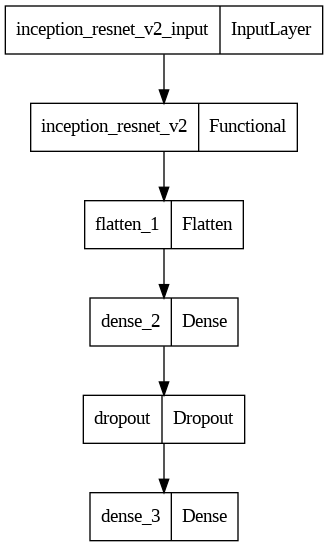

In [35]:
plot_model(model)

## Training

In [36]:
# Callbacks
Callbacks = [callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=0)]

In [37]:
model.fit(train_X, train_y, epochs=n_epochs, batch_size=32, validation_data=(test_X, test_y), callbacks=Callbacks)

Epoch 1/15
266/266 [==============================] - 42s 106ms/step - loss: 0.4281 - accuracy: 0.8693 - val_loss: 0.2577 - val_accuracy: 0.8987
Epoch 2/15
266/266 [==============================] - 24s 90ms/step - loss: 0.2349 - accuracy: 0.9026 - val_loss: 0.2332 - val_accuracy: 0.9087
Epoch 3/15
266/266 [==============================] - 22s 82ms/step - loss: 0.2114 - accuracy: 0.9147 - val_loss: 0.2117 - val_accuracy: 0.9227
Epoch 4/15
266/266 [==============================] - 24s 90ms/step - loss: 0.1937 - accuracy: 0.9221 - val_loss: 0.2175 - val_accuracy: 0.9167
Epoch 5/15
266/266 [==============================] - 22s 82ms/step - loss: 0.1718 - accuracy: 0.9318 - val_loss: 0.1945 - val_accuracy: 0.9327
Epoch 6/15
266/266 [==============================] - 25s 94ms/step - loss: 0.1623 - accuracy: 0.9365 - val_loss: 0.2181 - val_accuracy: 0.9133
Epoch 7/15
266/266 [==============================] - 22s 82ms/step - loss: 0.1485 - accuracy: 0.9421 - val_loss: 0.2195 - val_accuracy

## Save the model

In [38]:
# save the model
model.save('/content/drive/MyDrive/Model_Image/model_pretrain.h5')

In [39]:
# Delete the model
del model

## Test

In [40]:
# Pre-processing for test images
def test_preprocessing(img_path, gray=True):
    image = cv2.imread(img_path)
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_AREA)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

In [41]:
# load model
model = load_model('/content/drive/MyDrive/Model_Image/model_pretrain.h5')

In [42]:
import io
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

def visualize_image(image, y_pred):
    # Do the actual drawing in python
    fig = plt.figure(figsize=(3, 3), dpi=80)
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    if y_pred < 0.5:
      ax.text(2, 8, "Male",fontweight='bold', color='green',  bbox = dict(facecolor = 'gold', alpha =.9), fontsize='large')
    else:
      ax.text(0, 10, "Female",fontweight='bold', color='red',  bbox = dict(facecolor = 'gold', alpha =.9), fontsize='large')
    fig.canvas.draw()
    plt.tight_layout()

In [43]:
def inference(image_path):
  # read the test image
  img = cv2.imread(test_img_path)

  # Pre-processing
  test_image = test_preprocessing(test_img_path, gray)
  # prediction
  y_pred = model.predict(test_image, verbose=0)[0][0]

  # print(y_pred)
  visualize_image(img, y_pred)

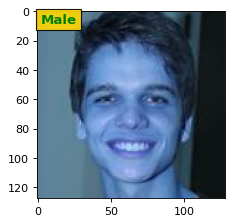

In [44]:
# test image path
test_img_path = '4.jpg'
inference(test_img_path)

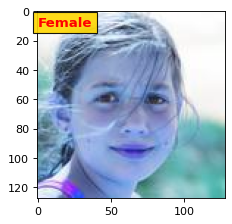

In [45]:
# test image path
test_img_path = '8.jpg'
inference(test_img_path)

47/47 [==============================] - 3s 64ms/step
Accuracy : 0.9226666666666666
Precision: 0.9316688567674113
Recall   : 0.9172056921086675
F1 score : 0.9243807040417211
Specificity : 0.9284731774415406

Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       727
           1       0.93      0.92      0.92       773

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500





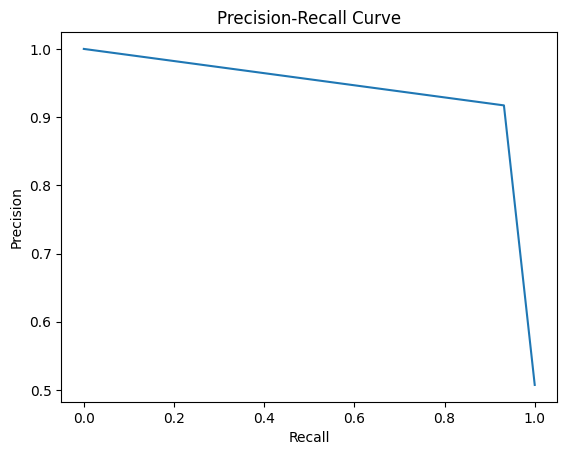

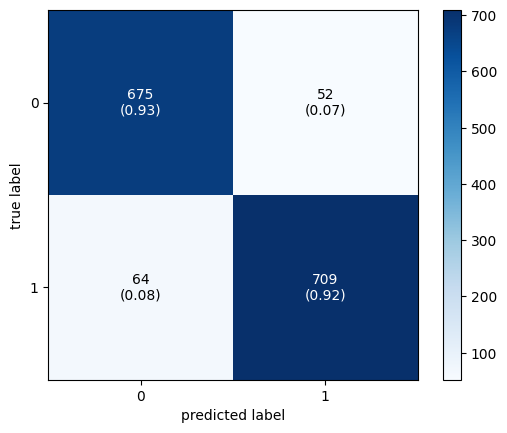

In [46]:
y_pred = model.predict(test_X)
y_predictions = map_y(y_pred)
cm = confusion_matrix(y_predictions, test_y)

tn = cm[0,0]
fp = cm[0,1]
tp = cm[1,1]
fn = cm[1,0]
accuracy  = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall    = tp / (tp + fn)
f1score  = 2 * precision * recall / (precision + recall)
specificity = tn / (tn + fp)
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'F1 score : {f1score}')
print(f'Specificity : {specificity}')
print("") 
print(f'Classification Report: \n{classification_report(y_predictions, test_y)}\n')
print("")

precision, recall, thresholds = precision_recall_curve(test_y, y_predictions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

# Plot non-normalized confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                            show_absolute=True,
                            show_normed=True,
                            colorbar=True)
plt.show()